In [1]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals
import pints
import numpy as np
import logging
import math

In [2]:

class SGD(pints.PopulationBasedOptimiser):
    """
    Finds the best parameters using the SGD method. 
    SGD stands for Stochastic Gradient Descent.
    """

    def __init__(self, x0, sigma0=None, boundaries=None, 
                     use_exact_grad=False):
        super(SGD, self).__init__(x0, sigma0, boundaries)

        # Set initial state
        self._running = False
        self._ready_for_tell = False

        # Best solution found
        self._xbest = pints.vector(x0)
        self._fbest = float('inf')

        # Python logger
        self._logger = logging.getLogger(__name__)
        self._population_size = 20
        
        # Do we use the approximate gradients?
        self._use_exact_grad = use_exact_grad

    def ask(self):
        """ See :meth:`Optimiser.ask()`. """
        # Initialise on first call
        if not self._running:
            self._initialise()

        # Ready for tell now
        self._ready_for_tell = True
      
        # New sample with all but one parameter fixed
        # Issue, our fbest and xbest are meaning less because we are not exploring on all 
        # params at the same time.. (isn't a huge issue however)
        self._xs = np.array([]).reshape(0,2)
        self._zs = np.array([np.random.normal(1, 0.005) 
                             for i in range(self._population_size)])
        for i in range(self._n_parameters):
            # Modify only for one parameter
            temp = np.full((self._population_size, self._n_parameters), self._weights)
            temp[:,i] *= self._zs
            self._xs = np.vstack([self._xs, temp])
        
        if self._manual_boundaries:
            # Manual boundaries? Then pass only xs that are within bounds
            self._user_ids = np.nonzero(
                [self._boundaries.check(x) for x in self._xs])
            self._user_xs = self._xs[self._user_ids]
            if len(self._user_xs) == 0:     # pragma: no cover
                self._logger.warning(
                    'All points requested by SGD are outside the boundaries.')
        else:
            self._user_xs = self._xs

        # Set as read-only and return
        self._user_xs.setflags(write=False)
        return self._user_xs

    def fbest(self):
        """ See :meth:`Optimiser.fbest()`. """
        return self._fbest

    def _initialise(self):
        """
        Initialises the optimiser for the first iteration.
        """
        assert(not self._running)
        
        #TODO, make change possible
        self._step_size = 0.00008
        
        self._manual_boundaries = False
        self._boundary_transform = None
        if isinstance(self._boundaries, pints.RectangularBoundaries):
            self._boundary_transform = pints.TriangleWaveTransform(
                self._boundaries)
        elif self._boundaries is not None:
            self._manual_boundaries = True

        self._weights = np.array(self._x0)
        
        # Update optimiser state
        self._running = True

    def name(self):
        """ See :meth:`Optimiser.name()`. """
        return 'Constant Step Stochastic Gradient Descent (SGD)'

    def running(self):
        """ See :meth:`Optimiser.running()`. """
        return self._running

    def set_step_size(self, step, scalar=True):
        self._step_size = step
        
    def gradient(self):
        return self._gradient

    def _suggested_population_size(self):
        """ See :meth:`Optimiser._suggested_population_size(). """
        return 4 + int(3 * np.log(self._n_parameters))

    def tell(self, fx):
        """ See :meth:`Optimiser.tell()`. """
        if not self._ready_for_tell:
            raise Exception('ask() not called before tell()')
        self._ready_for_tell = False

        
        if self._manual_boundaries and len(fx) < self._population_size:
            user_fx = fx
            fx = np.ones((self._population_size, )) * float('inf')
            fx[self._user_ids] = user_fx
        
        
        if self._use_exact_grad:
            grads = [f[1] for f in fx]
            fx = [f[0] for f in fx]
            self._gradient = self._exact_grad(grads)
        else: 
            self._gradient = self._approx_grad(fx)
        order = np.argsort(fx)
                    
        self._weights -= self._step_size * self._gradient
                
        #if fx[order[0]] < self._fbest:
        self._fbest = fx[order[0]]
        self._xbest = self._xs[order[0]]

    # This should approximate the gradient. 
    # We are essentially approximating the partial derivative for each param
    def _approx_grad(self, scores):
        n = self._n_parameters
        p = self._population_size
        result = np.zeros(n)
        for i in range(n):
            for j in range(p):
                for k in range(p):
                    if j == k:
                        continue
                    result[i] += (scores[j + i*p] - scores[k + i*p]) / (self._user_xs[j + i*p][i] - self._user_xs[k + i*p][i])
        return result / (p * (p-1))

    # This function takes the gradients on each timestep t as input (so we are not computing the individual gradients here)
    # We are using the individual gradients and take the average to get an estimation of the real gradients for each 
    # time step t
    def _exact_grad(self, grads):
        n = self._n_parameters
        p = self._population_size
        result = np.zeros(n)
        for j in range(p):
                    result += grads[j]
        return result / p

    def xbest(self):
        """ See :meth:`Optimiser.xbest()`. """
        return self._xbest 
    
    def weights(self):
        return self._weights     

In [3]:
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.5, 500]
times = np.linspace(0, 1000, 1000)
values, gradients = model.simulateS1(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
my_problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score_sgd = pints.MeanSquaredError(my_problem)

# Select some boundaries
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])

# Choose an initial position
x0 = [0.3, 700]

grad [-5650.67941529   389.13027704]
ws [  0.75205435 699.96886958]

grad [4018.7410454   368.77792384]
ws [3.79418891e-01 6.84799385e+02]

grad [-4937.28482521   331.13368835]
ws [  0.71947073 670.79634663]

grad [3178.87663599  317.1525612 ]
ws [5.90829075e-01 6.57851067e+02]

grad [3452.68787055  293.17976513]
ws [4.32834476e-01 6.45871999e+02]

grad [-2661.44698483   264.679727  ]
ws [5.87999069e-01 6.34822888e+02]

grad [-3711.53761936   244.26645393]
ws [  0.65731669 624.61564012]

grad [2947.27758376  229.02572233]
ws [3.87796416e-01 6.15182281e+02]

grad [2891.20785111  211.58824338]
ws [4.11739627e-01 6.06454459e+02]

grad [2728.43790399  193.88433389]
ws [4.09353256e-01 5.98383615e+02]

grad [2502.53408779  179.30046944]
ws [4.02606305e-01 5.90926224e+02]

grad [2255.03435822  168.01736448]
ws [4.00237593e-01 5.84033186e+02]

grad [2127.96671994  153.24169573]
ws [4.06751319e-01 5.77664587e+02]

grad [1969.38242297  141.87403938]
ws [4.10880692e-01 5.71775751e+02]

grad [1825

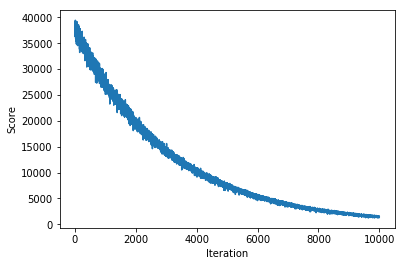

In [4]:
def SGD_approx_grad():
    # Create an SGD object
    sgd = SGD(x0, boundaries=boundaries)
    # Run optimisation
    best_fxs = []
    for i in range(10000):
        # Get the next points to evaluate
        xs = sgd.ask()
        # Evaluate the scores
        fxs = [score_sgd(x) for x in xs]
        # Pass the result back to SGD
        sgd.tell(fxs)
        if i % 5000 == 0:
            print("grad", sgd.gradient())
            print("ws", sgd.weights())
            print()
        # Store the best score
        best_fxs.append(sgd.fbest())
    return best_fxs, sgd.fbest(), sgd.xbest(), sgd.weights()

best_fxs, fbest, xbest, weights= SGD_approx_grad()
#print(xbest)
print(weights)
# Show how the score converges
axes = plt.gca()
plt.xlabel('Iteration')
plt.ylabel('Score')
#axes.set_ylim([-5,1000])
plt.plot(best_fxs)
plt.show()



grad [-5679.12961923   388.70337393]
ws [  0.75433037 699.96890373]

grad [-9006.47818936   357.85721756]
ws [  0.98868125 684.79673727]

grad [-261.98598236  334.79654512]
ws [4.29853423e-01 6.70790938e+02]

grad [-6184.44370983   307.01369303]
ws [  0.80648314 657.8445344 ]

grad [2081.35427389  287.57481733]
ws [3.34848082e-01 6.45863899e+02]

grad [-4227.31043154   262.9769109 ]
ws [  0.68693179 634.81888136]

grad [2543.07571629  246.53518951]
ws [3.49652157e-01 6.24611252e+02]

grad [-755.1577435   225.90690458]
ws [4.84268075e-01 6.15177147e+02]

grad [-3006.95787426   208.02443237]
ws [  0.61996767 606.45118881]

grad [-3051.7856676    192.24151663]
ws [  0.62412165 598.38420189]

grad [-2716.24168797   177.75848165]
ws [  0.60693356 590.92664668]

grad [-2272.96025901   164.40215327]
ws [5.82154318e-01 5.84032775e+02]

grad [-2041.81703721   151.99614173]
ws [5.69703513e-01 5.77660754e+02]

grad [-1938.56032834   140.49098041]
ws [5.66661560e-01 5.71771233e+02]

grad [-1877.11

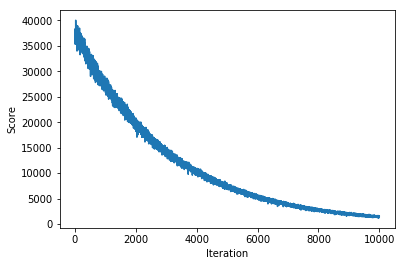

In [5]:
def SGD_real_grad():
    # Create an SGD object
    sgd = SGD(x0, boundaries=boundaries, use_exact_grad=True)
    # Run optimisation
    best_fxs = []
    for i in range(10000):
        # Get the next points to evaluate
        xs = sgd.ask()
        # Evaluate the scores
        grads = [score_sgd.evaluateS1(x) for x in xs]        
        # Pass the result back to SGD
        sgd.tell(grads)
        if i % 5000 == 0:
            print("grad", sgd.gradient())
            print("ws", sgd.weights())
            print()
        # Store the best score
        best_fxs.append(sgd.fbest())

    return best_fxs, sgd.fbest(), sgd.xbest(), sgd.weights()
    
best_fxs, fbest, xbest, weights = SGD_real_grad()
#print(xbest)
print(weights)
# Show how the score converges
axes = plt.gca()
plt.xlabel('Iteration')
plt.ylabel('Score')
#axes.set_ylim([-5,1000])
plt.plot(best_fxs)
plt.show()

In [7]:
win_count = []
f_diff = []
for i in range(20):
    _, approx_f, _, _ = SGD_approx_grad()
    _, exact_f, _, _ = SGD_real_grad()
    f_diff.append(approx_f - exact_f)
    win_count.append(1 if approx_f > exact_f else -1)

count_sum = sum(win_count)
diff_sum = sum(f_diff)
print("APPROX WINS" if count_sum < 0 else "REAL WINS", "on counts")
print("APPROX WINS" if diff_sum < 0 else "REAL WINS", "on diff")
print(count_sum)
print(diff_sum)

grad [-5715.22205265   385.16854131]
ws [  0.75721776 699.96918652]

grad [3267.94029719  369.7552578 ]
ws [6.32208648e-01 6.84802126e+02]

grad [ 92.37558948 333.32714756]
ws [4.11467751e-01 6.70794224e+02]

grad [3428.86140736  315.07553959]
ws [3.16386096e-01 6.57851952e+02]

grad [345.93781225 289.59463791]
ws [4.09698598e-01 6.45871575e+02]

grad [-891.48732438  264.17194202]
ws [4.83322218e-01 6.34824668e+02]

grad [-4316.3249541    243.56091316]
ws [  0.69608579 624.61735502]

grad [-3996.48651662   225.50678008]
ws [  0.67858285 615.17908865]

grad [-1627.78810989   206.86800361]
ws [5.37391177e-01 6.06452052e+02]

grad [-1652.93050765   191.38005839]
ws [5.41644309e-01 5.98386784e+02]

grad [-2125.36760588   177.65774168]
ws [5.71351580e-01 5.90926979e+02]

grad [-2142.47058716   163.77118541]
ws [5.74680701e-01 5.84032698e+02]

grad [-2096.10374532   151.67251538]
ws [5.73806729e-01 5.77661146e+02]

grad [-1980.67055496   142.07618598]
ws [5.68212412e-01 5.71769788e+02]

grad

grad [1598.2755958   112.54173563]
ws [4.24872624e-01 5.56644246e+02]

grad [1466.54299254  103.99365431]
ws [4.29350490e-01 5.52346741e+02]

grad [1370.24639557   96.12052941]
ws [4.33170952e-01 5.48374868e+02]

grad [1151.5106007    88.74367551]
ws [4.39913539e-01 5.44704031e+02]

grad [-5675.94473232   387.57425722]
ws [  0.75407558 699.96899406]

grad [3575.20651597  369.85914979]
ws [5.40106945e-01 6.84797674e+02]

grad [3371.76771219  345.09186717]
ws [5.63024315e-01 6.70794458e+02]

grad [1444.57398025  310.17126603]
ws [3.50843754e-01 6.57846441e+02]

grad [3479.49399568  293.20770307]
ws [3.93647487e-01 6.45869219e+02]

grad [-1398.20689618   263.96932505]
ws [5.12480389e-01 6.34823262e+02]

grad [2794.09936081  248.66052265]
ws [3.52311141e-01 6.24614098e+02]

grad [3055.64896312  228.72362065]
ws [4.26328318e-01 6.15179418e+02]

grad [2846.7795385   212.81260658]
ws [4.00670185e-01 6.06453513e+02]

grad [2717.62771177  194.89323567]
ws [4.06993944e-01 5.98387727e+02]

grad [

grad [-2170.94317164   151.95372621]
ws [  0.57784167 577.6592905 ]

grad [-2002.31936521   140.46893271]
ws [5.69732735e-01 5.71769831e+02]

grad [-1835.71217237   129.85338629]
ws [5.61863989e-01 5.66326421e+02]

grad [-1698.79364671   120.03398218]
ws [5.56169853e-01 5.61295383e+02]

grad [-1592.8057166    110.94986334]
ws [5.51874137e-01 5.56645508e+02]

grad [-1461.87902591   102.56238241]
ws [5.45351870e-01 5.52347961e+02]

grad [-1297.70778431    94.82233612]
ws [5.37720385e-01 5.48375990e+02]

grad [-1227.88383782    87.64244301]
ws [5.34929421e-01 5.44705109e+02]

grad [-5709.92418646   385.50217314]
ws [  0.75679393 699.96915983]

grad [-2904.31758224   360.12508629]
ws [5.82233349e-01 6.84799832e+02]

grad [-6120.01542367   328.54500836]
ws [  0.79828492 670.7973917 ]

grad [3187.21700602  311.65779831]
ws [3.07323957e-01 6.57846746e+02]

grad [-2481.82769506   287.25502854]
ws [5.72363951e-01 6.45861944e+02]

grad [251.33770806 263.59393123]
ws [4.21858969e-01 6.34812714e+0

grad [-3356.68619635   207.91451999]
ws [  0.64146763 606.45150492]

grad [-3094.25152277   192.22908603]
ws [  0.62781182 598.38446261]

grad [-2624.98949298   177.78659978]
ws [  0.60089914 590.92687678]

grad [-2126.07629693   164.44788865]
ws [5.73203774e-01 5.84032901e+02]

grad [-2169.04303728   151.95734701]
ws [5.77494310e-01 5.77660847e+02]

grad [-1928.97391074   140.49409176]
ws [5.65598270e-01 5.71771318e+02]

grad [-1890.65335313   129.83961161]
ws [5.66187313e-01 5.66327852e+02]

grad [-1653.36087021   120.05038235]
ws [5.53148925e-01 5.61296689e+02]

grad [-1562.67046365   110.96144558]
ws [5.50535776e-01 5.56646736e+02]

grad [-1462.50263034   102.56426336]
ws [5.45722773e-01 5.52349045e+02]

grad [-1357.79113363    94.80563797]
ws [5.41215886e-01 5.48377009e+02]

grad [-1159.6473755     87.66578006]
ws [5.31420428e-01 5.44706072e+02]

grad [-5647.35114913   389.3312068 ]
ws [  0.75178809 699.9688535 ]

grad [-8635.03672025   356.54951057]
ws [  0.96314304 684.805813  ]

grad [-5766.66249061   307.18932855]
ws [  0.77927561 657.85013116]

grad [-2400.90172111   285.20380291]
ws [5.68079366e-01 6.45868276e+02]

grad [-1069.09830301   264.18736843]
ws [4.93945219e-01 6.34821507e+02]

grad [-4281.48265517   243.06809274]
ws [  0.69415765 624.6138429 ]

grad [2546.95460114  228.13767831]
ws [3.62696433e-01 6.15178054e+02]

grad [2870.99874718  211.92063401]
ws [4.07215995e-01 6.06452122e+02]

grad [1967.61363789  194.63512125]
ws [3.81273275e-01 5.98384982e+02]

grad [2075.01476761  180.16375123]
ws [3.88802644e-01 5.90927362e+02]

grad [2222.87764436  166.88356794]
ws [3.99847721e-01 5.84033323e+02]

grad [2130.53007617  154.30321565]
ws [4.06595864e-01 5.77661257e+02]

grad [2001.06629517  142.6138944 ]
ws [4.11552537e-01 5.71771697e+02]

grad [1850.41468574  131.77803226]
ws [4.16050290e-01 5.66328134e+02]

grad [1705.6621568   121.76660672]
ws [4.19032552e-01 5.61296958e+02]

grad [1527.78314828  112.47913992]
ws [4.24765727e-01 5.56646862e+02]

grad [

grad [-1173.10635372    87.48157872]
ws [5.32527743e-01 5.44702821e+02]

grad [-5672.53700405   388.70687232]
ws [  0.75380296 699.96890345]

grad [3859.51583657  365.79139125]
ws [2.79487685e-01 6.84791891e+02]

grad [1296.41628009  335.68634707]
ws [3.4935198e-01 6.7078637e+02]

grad [3268.54999367  315.90414393]
ws [5.63049880e-01 6.57839362e+02]

grad [-5691.25138602   283.93346881]
ws [  0.77923828 645.8581462 ]

grad [3239.88387486  267.77729195]
ws [3.66879958e-01 6.34811406e+02]

grad [-3587.11026074   243.28440414]
ws [  0.64984406 624.60539849]

grad [1574.47394082  227.15140059]
ws [3.75979310e-01 6.15171813e+02]

grad [1709.97371461  210.17824968]
ws [3.78702730e-01 6.06445758e+02]

grad [1949.33984155  194.60577405]
ws [3.79532097e-01 5.98379173e+02]

grad [2194.81880321  180.3003868 ]
ws [3.90650644e-01 5.90921973e+02]

grad [2275.4893158   166.95501667]
ws [4.00750749e-01 5.84028442e+02]

grad [2129.1863088   154.29194141]
ws [4.06407146e-01 5.77656684e+02]

grad [1988.2

grad [-1726.84675056   118.85850503]
ws [5.57948455e-01 5.61297231e+02]

grad [-1543.39272811   111.65162416]
ws [5.48426746e-01 5.56650678e+02]

grad [-1389.84810304   101.06530465]
ws [5.42227944e-01 5.52353280e+02]

grad [-1294.21201693    94.80819629]
ws [5.37717370e-01 5.48379883e+02]

grad [-1147.83602646    88.71951445]
ws [5.30702795e-01 5.44708988e+02]

grad [-5664.32675973   388.71124021]
ws [  0.75314614 699.9689031 ]

grad [-4343.96537177   360.0694405 ]
ws [6.74203934e-01 6.84803356e+02]

grad [-6811.4165513   331.8386849]
ws [  0.84394109 670.79675381]

grad [3190.12377146  316.15078968]
ws [5.88196428e-01 6.57850238e+02]

grad [1867.12890823  287.41294085]
ws [3.42412865e-01 6.45869694e+02]

grad [-2635.31784224   263.56516605]
ws [5.86602831e-01 6.34823886e+02]

grad [-484.74366811  244.48754802]
ws [4.65220193e-01 6.24614850e+02]

grad [-921.74648336  225.84327418]
ws [4.93425129e-01 6.15179940e+02]

grad [-1743.67832276   208.45636656]
ws [5.43609183e-01 6.06453802e+0

[4.98916907e-01 4.99639129e+02]


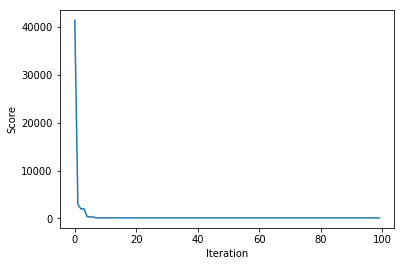

In [11]:
# Create an XNES object
xnes = pints.XNES(x0, boundaries=boundaries)

# Run optimisation
best_fx = []
for i in range(100):
    # Get the next points to evaluate
    xs = xnes.ask()
    # Evaluate the scores
    fxs = [score_sgd(x) for x in xs]
    # Pass the result back to XNES
    xnes.tell(fxs)
    # Store the best score
    best_fx.append(xnes.fbest())

# Show how the score converges
print(xnes.xbest())
plt.figure()
axes = plt.gca()
#axes.set_ylim([-5,1000])
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.plot(best_fx)
plt.show()